## 1. Libraries and settings

In [2]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn-v0_8-darkgrid')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

import vectorbtpro as vbt

from datetime import date

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter("ignore", UserWarning)

vbt.settings.set_theme('dark')
vbt.settings['plotting']['layout']['width'] = 800
vbt.settings['plotting']['layout']['height'] = 400

sequence_length = 80  # Example: 20 timesteps per sequence
# Update these dimensions based on your dataset
input_dim = 175  # Number of features
hidden_dim = 64
num_layers = 4
output_dim = 3  # Number of classes

num_epochs = 500
learning_rate=0.03
step_size=20
gamma=0.8

In [3]:
df = pd.read_csv('2ySOLdata1h.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.set_index('timestamp', inplace=True)

df['signal'] = df['signal'].replace({'SignalNone': 1, 'SignalLong': 2, 'SignalShort': 0})
df.fillna(method='pad');


/var/folders/x1/twdts0414gn1_4rw0fsqsphm0000gn/T/ipykernel_31429/3057766720.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['signal'] = df['signal'].replace({'SignalNone': 1, 'SignalLong': 2, 'SignalShort': 0})
/var/folders/x1/twdts0414gn1_4rw0fsqsphm0000gn/T/ipykernel_31429/3057766720.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='pad');


In [4]:
data = vbt.Data.from_data(df)
features = data.run("talib", mavp=vbt.run_arg_dict(periods=14))
data.data['symbol'] = pd.concat([data.data['symbol'], features], axis=1)
data.data['symbol'].drop(['Open', 'High', 'Low'], axis=1, inplace=True)
# This will drop columns from the DataFrame where all values are NaN
data.data['symbol'] = data.data['symbol'].dropna(axis=1, how='all')

open_price = data.get('Open')
high_price = data.get('High')
low_price = data.get('Low')
close_price = data.get('Close')

data.data['symbol'] = data.data['symbol'].dropna()
predictor_list = data.data['symbol'].drop('signal', axis=1).columns.tolist()


X = data.data['symbol'][predictor_list]

y = data.data['symbol']['signal']
X.columns = X.columns.astype(str)

In [10]:
test_size = int(0.3*(len(X)))
X_train = X[:-test_size]
X_test = X[-test_size:]

y_train = y[:-test_size]
y_test = y[-test_size:]



In [11]:
from sklearn.preprocessing import StandardScaler

# Create a scaler instance
scaler = StandardScaler()

# Fit the scaler to your data and transform
X_train_scaled = scaler.fit_transform(X_train)

# Create a DataFrame from the scaled data with the same index and columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)


# Fit the scaler to your data and transform
X_test_scaled = scaler.fit_transform(X_test)

# Create a DataFrame from the scaled data with the same index and columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

In [13]:


def create_sequences(input_data, sequence_length):
    sequences = []
    data_len = len(input_data)
    for i in range(data_len - sequence_length):
        seq = input_data[i:(i + sequence_length)]
        sequences.append(seq)
    return np.array(sequences)

# Assuming X_train_scaled_df and X_test_scaled_df are already scaled and are DataFrames
X_train_list = create_sequences(X_train_scaled_df.values, sequence_length)
X_test_list = create_sequences(X_test_scaled_df.values, sequence_length)

y_train_list = y_train[sequence_length:]
y_test_list = y_test[sequence_length:]



In [14]:
x_train = np.array(X_train_list)
x_test = np.array(X_test_list)  

y_train = np.array(y_train_list)
y_test = np.array(y_test_list)

In [15]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()

In [16]:
from sklearn.utils.class_weight import compute_class_weight

# Assuming y_train is your target labels tensor for the training data
# and it's already in the form of a 1D tensor of class indices (0 to C-1)

# Convert y_train to a numpy array if it's a tensor
if isinstance(y_train, torch.Tensor):
    y_train_np = y_train.cpu().numpy()
else:
    y_train_np = y_train  # Assuming y_train is already a numpy array

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_np), y=y_train_np)

# Convert class weights to a tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)


In [17]:
# Move class weights to the same device as your model and data
class_weights_tensor = class_weights_tensor.to('cpu')  # device could be 'cpu' or 'cuda'



In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout_rate=0.5):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM Layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # Forward propagate LSTM
        out, (hn, cn) = self.lstm(x, (h0, c0))
        
        # Apply dropout to the output of the LSTM
        out = self.dropout(out)
        
        # Take the output of the last time step
        out = self.fc(out[:, -1, :])
        
        return out



# Create the model
model = LSTMClassifier(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim)

# Use CrossEntropyLoss for multi-class classification
# Initialize the loss function with class weights
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Assuming `optimizer` is your optimizer (e.g., Adam)
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=step_size, gamma=gamma)


# Print the model's architecture
# print(model)


In [19]:

# Assuming loss_fn is already defined as CrossEntropyLoss
# e.g., loss_fn = torch.nn.CrossEntropyLoss()
# For classification, it might be more informative to track accuracy or other metrics
# hist will track the loss for now
hist = np.zeros(num_epochs)

for t in range(num_epochs):
    # Forward pass: Compute predicted y by passing x to the model
    y_train_pred = model(x_train)

    # Compute loss
    loss = loss_fn(y_train_pred, y_train.long())  # Ensure y_train is of type torch.long
    if t % 10 == 0:  # Adjust logging frequency according to your preference
        print("Epoch ", t, "Loss: ", loss.item())
    hist[t] = loss.item()

    # Zero gradients before backward pass
    optimiser.zero_grad()

    # Perform backward pass: compute gradients of the loss with respect to all the learnable parameters
    loss.backward()

    # Update the parameters using the gradients and optimizer algorithm
    optimiser.step()
    
    # Step the scheduler
    scheduler.step()

    # Optional: Calculate and print accuracy or other metrics every few epochs
    # This is more meaningful for classification tasks
    if t % 10 == 0:  # Adjust as needed
        with torch.no_grad():  # No need to track gradients for validation
            y_pred_tags = torch.argmax(torch.softmax(y_train_pred, dim=1), dim=1)
            correct_preds = (y_pred_tags == y_train).float().sum()
            accuracy = correct_preds / y_train.shape[0]
            print(f'Epoch {t} Accuracy: {accuracy.item() * 100:.2f}%')


Epoch  0 Loss:  1.1030863523483276
Epoch 0 Accuracy: 59.36%
Epoch  10 Loss:  0.7109286785125732
Epoch 10 Accuracy: 35.05%
Epoch  20 Loss:  0.5307205319404602
Epoch 20 Accuracy: 47.33%
Epoch  30 Loss:  0.3697407841682434
Epoch 30 Accuracy: 71.86%
Epoch  40 Loss:  0.22956323623657227
Epoch 40 Accuracy: 81.22%
Epoch  50 Loss:  0.1278403103351593
Epoch 50 Accuracy: 90.25%
Epoch  60 Loss:  0.09753622859716415
Epoch 60 Accuracy: 96.27%
Epoch  70 Loss:  0.04658012092113495
Epoch 70 Accuracy: 97.52%
Epoch  80 Loss:  0.028517084196209908
Epoch 80 Accuracy: 98.60%
Epoch  90 Loss:  0.01971004717051983
Epoch 90 Accuracy: 99.21%
Epoch  100 Loss:  0.012555504217743874
Epoch 100 Accuracy: 99.55%
Epoch  110 Loss:  0.00888978224247694
Epoch 110 Accuracy: 99.65%
Epoch  120 Loss:  0.008655235171318054
Epoch 120 Accuracy: 99.78%
Epoch  130 Loss:  0.006469960790127516
Epoch 130 Accuracy: 99.83%
Epoch  140 Loss:  0.005108599551022053
Epoch 140 Accuracy: 99.84%
Epoch  150 Loss:  0.005393306724727154
Epoch 15

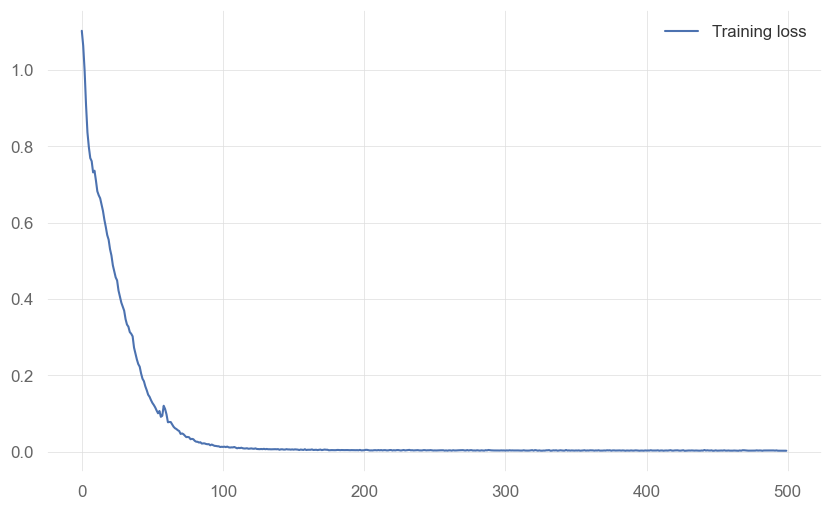

In [20]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [21]:
with torch.no_grad():
    
    y_test_pred = model(x_test)
    # Convert logits to probabilities
    probabilities = torch.softmax(y_test_pred, dim=1)

    # Get the predicted class labels
    _, predicted_labels = torch.max(probabilities, 1)
predicted_labels_numpy = predicted_labels.numpy()
len(predicted_labels_numpy)


5143

In [22]:
df_split = data.data['symbol'][-len(predicted_labels_numpy):].copy()
# len(df_split)
# df_split.shape
# predicted_labels_numpy.shape
df_split.loc[:, "signal"] = predicted_labels_numpy
signal = df_split['signal']
entries = signal == 2
exits = signal == 0

In [23]:
pf = vbt.Portfolio.from_signals(
    close=df_split.Close, 
    long_entries=entries, 
    long_exits=exits,
    size=100,
    size_type='value',
    init_cash='auto'
)

In [24]:
pf.plot(settings=dict(bm_returns=False)).show()

In [25]:
pf.stats()

Start                         2023-05-31 00:00:00+00:00
End                           2023-12-31 06:00:00+00:00
Period                                214 days 07:00:00
Start Value                                  121.431552
Min Value                                     91.370383
Max Value                                    165.337651
End Value                                    145.540926
Total Return [%]                              19.854291
Benchmark Return [%]                         377.151196
Total Time Exposure [%]                       48.668093
Max Gross Exposure [%]                            100.0
Max Drawdown [%]                              26.842545
Max Drawdown Duration                  71 days 08:00:00
Total Orders                                        121
Total Fees Paid                                     0.0
Total Trades                                         61
Win Rate [%]                                       65.0
Best Trade [%]                                10

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Convert tensors to numpy arrays for use with Scikit-Learn
true_labels = y_test.cpu().numpy()
pred_labels = predicted_labels.cpu().numpy()

precision = precision_score(true_labels, pred_labels, average='macro')  # 'macro' for unweighted mean
recall = recall_score(true_labels, pred_labels, average='macro')
f1 = f1_score(true_labels, pred_labels, average='macro')
conf_matrix = confusion_matrix(true_labels, pred_labels)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print('Confusion Matrix:\n', conf_matrix)

Precision: 0.37
Recall: 0.38
F1 Score: 0.37
Confusion Matrix:
 [[  18  149    1]
 [ 211 4449  157]
 [   1  142   15]]
